## Loading the curated citations dataset and do processing

In [1]:
# All imports
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load all csv files and add them into one dataframe
files = glob.glob('citations_ids.csv/part-*')
citation_dataframes = [pd.read_csv(f, header=None, sep=',') for f in files]
citation_with_ids = pd.concat(citation_dataframes, ignore_index=True)

In [3]:
print(citation_with_ids.shape)
total_citations = citation_with_ids.shape[0]

(2645313, 8)


In [4]:
citation_with_ids.head()

,0,1,2,3,4,5,6,7
0,Ray Sharkey,1831197,Fatal Deceit,{ISSN=0093-7673},"[{last=Gliatto, first=Tom}]",NaN,cite journal,NaN
1,Protamine sulfate,1831220,Management of the patient with protamine hyper...,"{PMID=6334459, DOI=10.1097/00000542-198412000-...","[{last=Campbell, first=FW}, {last=Goldstein, M...",NaN,cite journal,NaN
2,Protamine sulfate,1831220,Protamine sulfate enhances lipid-mediated gene...,"{PMID=9349433, DOI=10.1038/sj.gt.3300484}","[{last=Sorgi, first=FL}, {last=Bhattacharya, S...",NaN,cite journal,NaN
3,Protamine sulfate,1831220,WHO Model Formulary 2008,{ISBN=9789241547659},NaN,World Health Organization,cite book,NaN
4,Protamine sulfate,1831220,Protamine sulfate as an effective alternative ...,"{PMID=2786000, DOI=10.1016/0166-0934(89)90132-8}","[{last=Kenneth Cornetta}, {last=W.French Ander...",NaN,cite journal,NaN


In [5]:
citation_with_ids.columns = [
    'title_of_page', 'id', 'title_of_citation', 'id_list', 'authors',
    'publisher_place', 'type_of_citation', 'publisher_name'
]

In [6]:
citation_with_ids.head()

,title_of_page,id,title_of_citation,id_list,authors,publisher_place,type_of_citation,publisher_name
0,Ray Sharkey,1831197,Fatal Deceit,{ISSN=0093-7673},"[{last=Gliatto, first=Tom}]",NaN,cite journal,NaN
1,Protamine sulfate,1831220,Management of the patient with protamine hyper...,"{PMID=6334459, DOI=10.1097/00000542-198412000-...","[{last=Campbell, first=FW}, {last=Goldstein, M...",NaN,cite journal,NaN
2,Protamine sulfate,1831220,Protamine sulfate enhances lipid-mediated gene...,"{PMID=9349433, DOI=10.1038/sj.gt.3300484}","[{last=Sorgi, first=FL}, {last=Bhattacharya, S...",NaN,cite journal,NaN
3,Protamine sulfate,1831220,WHO Model Formulary 2008,{ISBN=9789241547659},NaN,World Health Organization,cite book,NaN
4,Protamine sulfate,1831220,Protamine sulfate as an effective alternative ...,"{PMID=2786000, DOI=10.1016/0166-0934(89)90132-8}","[{last=Kenneth Cornetta}, {last=W.French Ander...",NaN,cite journal,NaN


In [7]:
# Percentage of values present for title of page, title of citation and authors
(citation_with_ids.count() * 100) / total_citations

title_of_page         99.999924
id                   100.000000
title_of_citation     99.918913
id_list              100.000000
authors               93.071595
publisher_place       57.745832
type_of_citation     100.000000
publisher_name        23.840392
dtype: float64

In [8]:
# Formulate a structure for the ID_List in which we can do something meaningful
citation_with_ids['id_list'] = citation_with_ids['id_list'].apply(
    lambda x: list(item.split('=') for item in x.replace('{','').replace('}','').replace(' ', '').split(','))
)

In [9]:
# Get the kinds of ids associated with each tuple
kinds_of_ids = set()
def update_ids(x):
    for item in x:
        kinds_of_ids.add(item[0])

_ = citation_with_ids['id_list'].apply(lambda x: update_ids(x))

# Add the columns with NoneType in the previous DF
for id_ in kinds_of_ids:
    citation_with_ids[id_] = None

In [10]:
print('Total kind of Citation IDs: {}'.format(len(kinds_of_ids)))

Total kind of Citation IDs: 60


In [11]:
# Set the value of identifiers for each column, for e.g. DOI, ISBN etc.
def set_citation_val(x):
    for item in x['id_list']:
        citation_with_ids.at[x.name, item[0]] = item[1] if len(item) >= 2 else None

_ = citation_with_ids.apply(lambda x: set_citation_val(x), axis=1)

In [12]:
citation_with_ids.head()

,title_of_page,id,title_of_citation,id_list,authors,publisher_place,type_of_citation,publisher_name,DOI,ISBN,...,5-79-051006-X,9780806379999,5-7905-1008-6,+xin,andtheirabilitytoself-organize,cribb,No.3(Summer,MR,ZBL,PMID
0,Ray Sharkey,1831197,Fatal Deceit,"[[ISSN, 0093-7673]]","[{last=Gliatto, first=Tom}]",NaN,cite journal,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Protamine sulfate,1831220,Management of the patient with protamine hyper...,"[[PMID, 6334459], [DOI, 10.1097/00000542-19841...","[{last=Campbell, first=FW}, {last=Goldstein, M...",NaN,cite journal,NaN,10.1097/00000542-198412000-00021,None,...,None,None,None,None,None,None,None,None,None,6334459
2,Protamine sulfate,1831220,Protamine sulfate enhances lipid-mediated gene...,"[[PMID, 9349433], [DOI, 10.1038/sj.gt.3300484]]","[{last=Sorgi, first=FL}, {last=Bhattacharya, S...",NaN,cite journal,NaN,10.1038/sj.gt.3300484,None,...,None,None,None,None,None,None,None,None,None,9349433
3,Protamine sulfate,1831220,WHO Model Formulary 2008,"[[ISBN, 9789241547659]]",NaN,World Health Organization,cite book,NaN,None,9789241547659,...,None,None,None,None,None,None,None,None,None,None
4,Protamine sulfate,1831220,Protamine sulfate as an effective alternative ...,"[[PMID, 2786000], [DOI, 10.1016/0166-0934(89)9...","[{last=Kenneth Cornetta}, {last=W.French Ander...",NaN,cite journal,NaN,10.1016/0166-0934(89)90132-8,None,...,None,None,None,None,None,None,None,None,None,2786000


### How do the identifiers appear with each other?

* Do we have citations with a lot of two identifiers?

In [13]:
identifiers_existing = citation_with_ids[['DOI', 'ISBN', 'ISSN', 'PMC', 'PMID']].notnull()

In [14]:
identifiers_existing.head()

,DOI,ISBN,ISSN,PMC,PMID
0,False,False,True,False,False
1,True,False,False,False,True
2,True,False,False,False,True
3,False,True,False,False,False
4,True,False,False,False,True


In [15]:
all_columns = identifiers_existing.columns
frequency_citation = dict()

def get_frequency_of_identifiers_appearing(x):
    available_citation_types = tuple([column for column in all_columns if x[column]])
    frequency_citation.setdefault(available_citation_types, 0)
    frequency_citation[available_citation_types] += 1

_ = identifiers_existing.apply(lambda x: get_frequency_of_identifiers_appearing(x), axis=1)

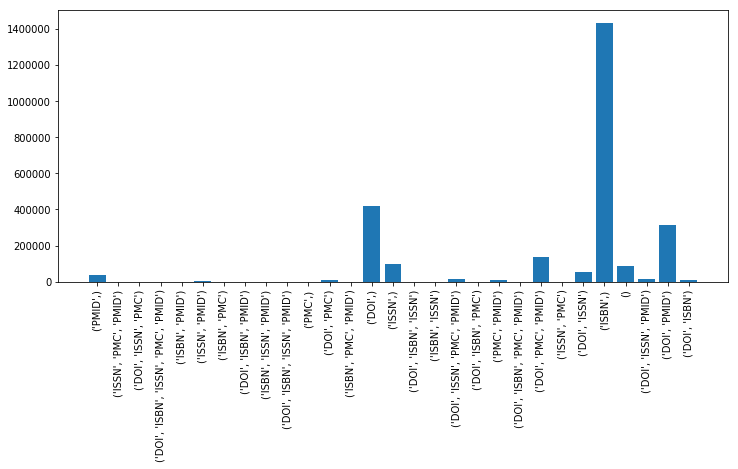

In [16]:
# Make a graph of the frequency distribution calculated above
names = list(frequency_citation.keys())
values = list(frequency_citation.values())

plt.rcParams["figure.figsize"] = (12,5)
plt.xticks(rotation=90)
plt.bar(range(len(frequency_citation)),values,tick_label=names)
plt.show()

## Loading the wikipedia dataset with identifiers

In [17]:
CITATION_WITH_IDENTIFIERS = '../Citations_with_Identifiers/enwiki.tsv.tar.gz'

wiki_en_identifiers = pd.read_csv(CITATION_WITH_IDENTIFIERS, compression='gzip', sep='\t')

In [18]:
wiki_en_identifiers.head(5)

,enwiki.tsv,page_title,rev_id,timestamp,type,id
0,2867096.0,Mu Aquilae,503137751.0,2012-07-19T16:08:41Z,doi,10.1051/0004-6361:20078357
1,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,astro-ph/0604502
2,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,astro-ph/0003329
3,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,0708.1752
4,2867096.0,Mu Aquilae,503137751.0,2012-07-19T16:08:41Z,doi,10.1051/0004-6361:20064946


In [19]:
print('Total citation identifiers for English Wikipedia: {}'.format(wiki_en_identifiers.shape[0]))

Total citation identifiers for English Wikipedia: 3794696


In [20]:
wiki_en_identifiers['type'].unique() # Labels which have unique IDSs

array(['doi', 'arxiv', 'isbn', 'pmid', 'pmc', nan], dtype=object)

In [21]:
# Remove the one with the NaN value
wiki_en_identifiers = wiki_en_identifiers[wiki_en_identifiers['type'].notnull()]

## Comparing the two datasets

The gap exists between the two datasets (3.8 mil, 2.7 mil) of about 1.1 million because we are looking only at certain citation formats which can be parsed by the `mwparserfromhell`. But still we have got 70% of the citation data by looking at just mere numbers.

In [22]:
gap = wiki_en_identifiers.shape[0] - total_citations

print('The total gap between between total number of wikipedias citations and our citations: {}'.format(gap))

The total gap between between total number of wikipedias citations and our citations: 1149382


In [23]:
def get_citations_specific_to_type(wiki_type, curated_type):
    type_wiki_identifiers = wiki_en_identifiers[wiki_en_identifiers['type'] == wiki_type]
    type_citations_curated = citation_with_ids[citation_with_ids[curated_type].notnull()]
    
    # Just considering the unique ones since they are a lot of duplicated DOIs
    # Maybe one citation is cited in many different pages
    number_of_identifiers_wiki = type_wiki_identifiers['id'].nunique()
    number_of_identifiers_curated = type_citations_curated['DOI'].nunique()
    print('The total number of unique {} wiki identifiers: {}'.format(wiki_type, number_of_identifiers_wiki))
    print('The total number of unique {} curated identifiers: {}'.format(curated_type, number_of_identifiers_curated))
    
    print('\nThe difference between wiki and curated is: {}'.format(
        number_of_identifiers_wiki - number_of_identifiers_curated)
    )
    
    return type_wiki_identifiers, type_citations_curated

### How many DOI identifiers are common?

In [24]:
doi_wiki_identifiers, doi_citations_curated = get_citations_specific_to_type('doi', 'DOI')

The total number of unique doi wiki identifiers: 864436
The total number of unique DOI curated identifiers: 715676

The difference between wiki and curated is: 148760


In [25]:
# Check if curated DOIs are contained in the already obtained dataset from Wikipedia
total_number_of_doi_identifiers_in_wiki = np.sum(doi_citations_curated['DOI'].isin(doi_wiki_identifiers['id']))

In [26]:
## DOI ids which are not present in the wiki dataset for identifiers
doi_identifiers_not_in_wiki = doi_citations_curated[~doi_citations_curated['DOI'].isin(doi_wiki_identifiers['id'])]['DOI'].nunique()
doi_citations_curated[~doi_citations_curated['DOI'].isin(doi_wiki_identifiers['id'])].head()

,title_of_page,id,title_of_citation,id_list,authors,publisher_place,type_of_citation,publisher_name,DOI,ISBN,...,5-79-051006-X,9780806379999,5-7905-1008-6,+xin,andtheirabilitytoself-organize,cribb,No.3(Summer,MR,ZBL,PMID
30,Ü-Tsang,1831291,Strategic Hypocrisy: The British Imperial Scri...,"[[DOI, 10.1017/s0021911809000011]]","[{last=Annand, first=Dibyesh}]",NaN,cite journal,NaN,10.1017/s0021911809000011,None,...,None,None,None,None,None,None,None,None,None,None
51,Ethylmercury,1831507,Thimerosal changes protein conformation and in...,"[[PMID, 29476861], [DOI, 10.1016/j.ijbiomac.20...","[{last=Santos, first=JC}, {last=da Silva, firs...",NaN,cite journal,NaN,10.1016/j.ijbiomac.2018.02.116,None,...,None,None,None,None,None,None,None,None,None,29476861
70,Existential therapy,1831754,Existential therapies: A meta-analysis of thei...,"[[DOI, 10.1037/a0037167]]","[{last=Vos, first=Jo\xebl}, {last=Craig, first...",NaN,cite journal,NaN,10.1037/a0037167,None,...,None,None,None,None,None,None,None,None,None,None
77,Existential therapy,1831754,Daseinsanalysis: A quest for essentials.,"[[DOI, 10.1080/08873267.1988.9976809]]","[{last=Craig, first=Erik}]",NaN,cite journal,NaN,10.1080/08873267.1988.9976809,None,...,None,None,None,None,None,None,None,None,None,None
95,Lucius Scribonius Libo,1832003,Scribonia and Her Daughters,"[[DOI, 10.2307/283429]]","[{last=Leon, first=Ernestine F.}]",NaN,cite journal,NaN,10.2307/283429,None,...,None,None,None,None,None,None,None,None,None,None


In [27]:
print(
    'Stats:\n Total Curated: {} In Wiki: {} Gap: {} -> Unique Ones: {}'.format(
        doi_citations_curated.shape[0],
        total_number_of_doi_identifiers_in_wiki,
        doi_citations_curated.shape[0] - total_number_of_doi_identifiers_in_wiki,
        doi_identifiers_not_in_wiki
    )
)

Stats:
 Total Curated: 973587 In Wiki: 907884 Gap: 65703 -> Unique Ones: 56621


### How many ISBN (also ISSN) identifiers are common?

* ISBNs are International Standard Book Numbers. They can be assigned to monographic publications, such as books, e-books and audiobooks.
* ISMNs are International Standard Music Numbers. They can be assigned to notated music (scores and sheet music) whether published in print, online or in other media.
* ISSNs are International Standard Serial Numbers. They can be assigned to periodical publications, such as magazines and journals.

In [28]:
isbn_wiki_identifiers, isbn_citations_curated = get_citations_specific_to_type('isbn', 'ISBN')

The total number of unique isbn wiki identifiers: 766185
The total number of unique ISBN curated identifiers: 10786

The difference between wiki and curated is: 755399


### Trying to normalize all the ISBN (also need to do for ISSN)

* So if '00-11-223344' it becomes '0011223344'

In [29]:
# Check if the wikipedia citation identifiers does not have hyphens
np.sum(isbn_wiki_identifiers['id'].apply(lambda x: '-' in x))

0

In [30]:
isbn_citations_curated['ISBN'] = isbn_citations_curated['ISBN'].apply(lambda x: x.replace('-', ''))

In [31]:
# Check if curated DOIs are contained in the already obtained dataset from Wikipedia
isbn_identifiers_not_in_wiki = isbn_citations_curated[~isbn_citations_curated['ISBN'].isin(isbn_wiki_identifiers['id'])]['ISBN'].nunique()
total_number_of_isbn_identifiers_in_wiki = np.sum(isbn_citations_curated['ISBN'].isin(isbn_wiki_identifiers['id']))

In [32]:
print(
    'Stats:\n Total Curated: {} In Wiki: {} Gap: {} -> Uniques Ones: {}'.format(
        isbn_citations_curated.shape[0],
        total_number_of_isbn_identifiers_in_wiki,
        isbn_citations_curated.shape[0] - total_number_of_isbn_identifiers_in_wiki,
        isbn_identifiers_not_in_wiki
    )
)

Stats:
 Total Curated: 1445740 In Wiki: 1377946 Gap: 67794 -> Uniques Ones: 53608


### Now time for ISSN...

In [33]:
# But the stats for this does not matter!!!
# because the hypothesis is that ISSN is contained inside ISBN - but only some of them do!
isbn_wiki_identifiers, issn_citations_curated = get_citations_specific_to_type('isbn', 'ISSN')

The total number of unique isbn wiki identifiers: 766185
The total number of unique ISSN curated identifiers: 73761

The difference between wiki and curated is: 692424


In [34]:
# Normalizing it again like ISBN
issn_citations_curated['ISSN'] = issn_citations_curated['ISSN'].apply(lambda x: x.replace('-', ''))

In [35]:
total_number_of_issn_identifiers_in_wiki = np.sum(issn_citations_curated['ISSN'].isin(isbn_wiki_identifiers['id']))

In [36]:
issn_identifiers_not_in_wiki = issn_citations_curated[~issn_citations_curated['ISSN'].isin(isbn_wiki_identifiers['id'])]['ISSN'].nunique()
issn_citations_curated[~issn_citations_curated['ISSN'].isin(isbn_wiki_identifiers['id'])]

,title_of_page,id,title_of_citation,id_list,authors,publisher_place,type_of_citation,publisher_name,DOI,ISBN,...,5-79-051006-X,9780806379999,5-7905-1008-6,+xin,andtheirabilitytoself-organize,cribb,No.3(Summer,MR,ZBL,PMID
0,Ray Sharkey,1831197,Fatal Deceit,"[[ISSN, 0093-7673]]","[{last=Gliatto, first=Tom}]",NaN,cite journal,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
24,Alex Shnaider,1831242,"Alex Shnaider, a Russian-born Canadian busines...","[[ISSN, 0319-0781]]",NaN,NaN,cite news,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
26,Lignan,1831262,Secondary metabolism in cannabis,"[[ISSN, 1568-7767], [DOI, 10.1007/s11101-008-9...","[{last=Flores-Sanchez, first=Isvett Josefina},...",NaN,cite journal,NaN,10.1007/s11101-008-9094-4,None,...,None,None,None,None,None,None,None,None,None,None
179,Swanson,1832791,Campbell Soup Co. Plans to Buy C. A. Swanson &...,"[[ISSN, 0362-4331]]",NaN,NaN,cite news,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
180,Thelon River,1832799,The Stefansson-Anderson Arctic Expedition of t...,"[[ISSN, 0065-9452], [OCLC, 1116815]]",NaN,American Museum of Natural History,cite journal,New York,None,None,...,None,None,None,None,None,None,None,None,None,None
219,Mystical Ninja Starring Goemon,1833226,Review of Mystical Ninja Starring Goemon,"[[ISSN, 1041-9551]]",NaN,Nintendo,cite journal,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
220,Mystical Ninja Starring Goemon,1833226,Epic Center News,"[[ISSN, 1041-9551]]","[{last=Averill, first=Alan}]",Nintendo,cite journal,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
221,Mystical Ninja Starring Goemon,1833226,Tokyo Game Show 1997,"[[ISSN, 1041-9551]]",NaN,Nintendo,cite journal,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
222,Mystical Ninja Starring Goemon,1833226,Preview of Mystical Ninja Starring Goemon,"[[ISSN, 1078-9693]]",NaN,Imagine Media,cite journal,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None
223,Mystical Ninja Starring Goemon,1833226,Pak Watch,"[[ISSN, 1041-9551]]",NaN,Nintendo,cite journal,NaN,None,None,...,None,None,None,None,None,None,None,None,None,None


In [37]:
print(
    'Stats:\n Total Curated: {} In Wiki: {} Gap: {} -> Unique Ones: {}'.format(
        issn_citations_curated.shape[0],
        total_number_of_issn_identifiers_in_wiki,
        issn_citations_curated.shape[0] - total_number_of_issn_identifiers_in_wiki,
        issn_identifiers_not_in_wiki
    )
)

Stats:
 Total Curated: 186698 In Wiki: 7127 Gap: 179571 -> Unique Ones: 27866


What we can see is that ISSN exists in our `curated` dataset and only some of them of these are contained in the existing `wikipedia dataset`. Most of them do not exist and hence the hypothesis is potentially not correct. Also, some of these can be counter examples since they are magazines and music volumes which are not scientific in nature.

### How many PMID identifiers are common?

In [38]:
pmid_wiki_identifiers, pmid_citations_curated = get_citations_specific_to_type('pmid', 'PMID')

The total number of unique pmid wiki identifiers: 421243
The total number of unique PMID curated identifiers: 342188

The difference between wiki and curated is: 79055


In [39]:
# Check if curated PMIDs are contained in the already obtained dataset from Wikipedia
total_number_of_pmid_identifiers_in_wiki = np.sum(pmid_citations_curated['PMID'].isin(pmid_wiki_identifiers['id']))

In [40]:
pmid_identifiers_not_in_wiki = pmid_citations_curated[~pmid_citations_curated['PMID'].isin(pmid_wiki_identifiers['id'])]['PMID'].nunique()

In [41]:
print(
    'Stats:\n Total Curated: {} In Wiki: {} Gap: {} -> Unique Ones: {}'.format(
        pmid_citations_curated.shape[0],
        total_number_of_pmid_identifiers_in_wiki,
        pmid_citations_curated.shape[0] - total_number_of_pmid_identifiers_in_wiki,
        pmid_identifiers_not_in_wiki
    )
)

Stats:
 Total Curated: 535557 In Wiki: 503088 Gap: 32469 -> Unique Ones: 29225


### How many PMC identifiers are common?

In [42]:
pmc_wiki_identifiers, pmc_citations_curated = get_citations_specific_to_type('pmc', 'PMC')

The total number of unique pmc wiki identifiers: 116132
The total number of unique PMC curated identifiers: 109368

The difference between wiki and curated is: 6764


In [43]:
# Check if curated PMCs are contained in the already obtained dataset from Wikipedia
total_number_of_pmc_identifiers_in_wiki = np.sum(pmc_citations_curated['PMC'].isin(pmc_wiki_identifiers['id']))

In [44]:
pmc_identifiers_not_in_wiki = pmc_citations_curated[~pmc_citations_curated['PMC'].isin(pmc_wiki_identifiers['id'])]['PMC'].nunique()

In [45]:
print(
    'Stats:\n Total Curated: {} In Wiki: {} Gap: {} -> Unique Ones: {}'.format(
        pmc_citations_curated.shape[0],
        total_number_of_pmc_identifiers_in_wiki,
        pmc_citations_curated.shape[0] - total_number_of_pmc_identifiers_in_wiki,
        pmc_identifiers_not_in_wiki
    )
)

Stats:
 Total Curated: 171690 In Wiki: 149184 Gap: 22506 -> Unique Ones: 19635


### How many ArXiV identifiers are common?

In [46]:
arxiv_wiki_identifiers, arxiv_citations_curated = get_citations_specific_to_type('arxiv', 'ARXIV')

The total number of unique arxiv wiki identifiers: 23781
The total number of unique ARXIV curated identifiers: 16560

The difference between wiki and curated is: 7221


In [47]:
# Check if curated PMCs are contained in the already obtained dataset from Wikipedia
total_number_of_arxiv_identifiers_in_wiki = np.sum(arxiv_citations_curated['ARXIV'].isin(arxiv_wiki_identifiers['id']))

In [48]:
arxiv_identifiers_not_in_wiki = arxiv_citations_curated[~arxiv_citations_curated['ARXIV'].isin(arxiv_wiki_identifiers['id'])]['PMC'].nunique()

In [49]:
print(
    'Stats:\n Total Curated: {} In Wiki: {} Gap: {} -> Unique Ones: {}'.format(
        arxiv_citations_curated.shape[0],
        total_number_of_arxiv_identifiers_in_wiki,
        arxiv_citations_curated.shape[0] - total_number_of_arxiv_identifiers_in_wiki,
        arxiv_identifiers_not_in_wiki
    )
)

Stats:
 Total Curated: 32904 In Wiki: 27473 Gap: 5431 -> Unique Ones: 139
